In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline



In [ ]:
import csv

In [ ]:
candidate_sentences = pd.read_csv("data_abstract.csv", encoding = "utf-8")
candidate_sentences.shape

(274, 8)

In [ ]:
candidate_sentences.head()

,Abstract,removed_punc,tokens,larger_tokens,clean_tokens,stem_words,lemma_words,clean_text
0,"In May 2012, the 65th World Health Assembly (WHA) approved six global nutrition \ntargets by 2025 aimed to reduce stunting in children under five by 40%, maintain \nchildhood wasting below 5%, hal...",In May 2012 the 65th World Health Assembly WHA approved six global nutrition \ntargets by 2025 aimed to reduce stunting in children under five by 40 maintain \nchildhood wasting below 5 halt obesi...,"['in', 'may', '2012', 'the', '65th', 'world', 'health', 'assembly', 'wha', 'approved', 'six', 'global', 'nutrition', 'targets', 'by', '2025', 'aimed', 'to', 'reduce', 'stunting', 'in', 'children',...","['2012', '65th', 'world', 'health', 'assembly', 'approved', 'global', 'nutrition', 'targets', '2025', 'aimed', 'reduce', 'stunting', 'children', 'under', 'five', 'maintain', 'childhood', 'wasting'...","['2012', '65th', 'world', 'health', 'assembly', 'approved', 'global', 'nutrition', 'targets', '2025', 'aimed', 'reduce', 'stunting', 'children', 'five', 'maintain', 'childhood', 'wasting', 'halt',...","['2012', '65th', 'world', 'health', 'assembl', 'approv', 'global', 'nutrit', 'target', '2025', 'aim', 'reduc', 'stunt', 'children', 'five', 'maintain', 'childhood', 'wast', 'halt', 'obes', 'anemia...","['2012', '65th', 'world', 'health', 'assembly', 'approved', 'global', 'nutrition', 'target', '2025', 'aimed', 'reduce', 'stunting', 'child', 'five', 'maintain', 'childhood', 'wasting', 'halt', 'ob...",2012 65th world health assembly approved global nutrition target 2025 aimed reduce stunting child five maintain childhood wasting halt obesity anemia woman lower birth weight prevalence increase e...
1,"OBJECTIVES: To analyze factors related to stunting in Papua region.\nMETHODS: Secondary data from the 2021 Indonesian National Nutrition Status \nSurvey were used in this study. Samples of 2,937 P...",OBJECTIVES To analyze factors related to stunting in Papua region\nMETHODS Secondary data from the 2021 Indonesian National Nutrition Status \nSurvey were used in this study Samples of 2937 Papuan...,"['objectives', 'to', 'analyze', 'factors', 'related', 'to', 'stunting', 'in', 'papua', 'region', 'methods', 'secondary', 'data', 'from', 'the', '2021', 'indonesian', 'national', 'nutrition', 'stat...","['objectives', 'analyze', 'factors', 'related', 'stunting', 'papua', 'region', 'methods', 'secondary', 'data', 'from', '2021', 'indonesian', 'national', 'nutrition', 'status', 'survey', 'were', 'u...","['objectives', 'analyze', 'factors', 'related', 'stunting', 'papua', 'region', 'methods', 'secondary', 'data', '2021', 'indonesian', 'national', 'nutrition', 'status', 'survey', 'used', 'study', '...","['object', 'analyz', 'factor', 'relat', 'stunt', 'papua', 'region', 'method', 'secondari', 'data', '2021', 'indonesian', 'nation', 'nutrit', 'statu', 'survey', 'use', 'studi', 'sampl', '2937', 'pa...","['objective', 'analyze', 'factor', 'related', 'stunting', 'papua', 'region', 'method', 'secondary', 'data', '2021', 'indonesian', 'national', 'nutrition', 'status', 'survey', 'used', 'study', 'sam...",objective analyze factor related stunting papua region method secondary data 2021 indonesian national nutrition status survey used study sample 2937 papuan child gathered study study analyzed inde...
2,Because of the indispensable amino acids dietary proteins are the most important \nmacronutrients. Proper growth and body maintenance depends on the quantity and \nquality of protein intake and pr...,Because of the indispensable amino acids dietary proteins are the most important \nmacronutrients Proper growth and body maintenance depends on the quantity and \nquality of protein intake and pro...,"['because', 'of', 'the', 'indispensable', 'amino', 'acids', 'dietary', 'proteins', 'are', 'the', 'most', 'important', 'macronutrients', 'proper', 'growth', 'and', 'body', 'maintenance', 'depends',...","['because', 'indispensable', 'amino', 'acids', 'dietary', 'proteins', 'most'

In [ ]:
candidate_sentences['Abstract'].sample(5)

139    Maize is a staple crop in rural subsistence regions of southern Africa, is \nmainly produced for direct household consumption and is often contaminated with \nhigh levels of mycotoxins. Chronic ex...
69     BACKGROUND: Stunting remains a significant public health issue in Rwanda and its \nprevalence exhibits considerable geographical variation. We apply Bayesian \ngeostatistical modelling to study th...
149    BACKGROUND: The prevalence of growth disorders among school-aged children in \nIndonesia is high (30.7%). Pesticides have been massively used in Indonesian \nagricultural areas.\nOBJECTIVE: To det...
17     BACKGROUND: Childhood stunting is a major public health problem globally, \nresulting in poor cognition and educational performance, low adult wages, low \nproductivity, and an increased risk of n...
191    BACKGROUND: Growth stunting in children under 2 years of age in low-income \ncountries is common. Giardia is a ubiquitous pathogen in this age group but \nstudies in

In [ ]:

doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
entity_pairs = []

for i in tqdm(candidate_sentences["Abstract"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 274/274 [00:17<00:00, 15.85it/s]


In [ ]:
entity_pairs[10:20]

[['poor risk growth', 'middleincome country zinc deficiency population'],
 ['crucial wealth status intervention', 'stunting  child'],
 ['1·46 2·05 0·001 intervention group',
  'stunting malnutrition prevention pakistan'],
 ['linear adolescent caution', 'intake protein consumption protein'],
 ['longertime childrens', 'outcome policy decision'],
 ['prenatal vitamin supplementation', 'needed prevent stunting'],
 ['based  model', 'maternal child health'],
 ['stunting density travel child', 'health extension program'],
 ['increase kidmed increase score',
  'life gastrointestinal health child disability'],
 ['consumption stunting promote importance consuming',
  'prevent stunting child bandar lampung']]

In [ ]:
len(entity_pairs)

274

In [ ]:
new_list = [[s for s in l if len(s)>0] for l in entity_pairs]
entity_pairs_1 = [x for x in new_list if x]

In [ ]:
len(entity_pairs_1)

274

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object
  matcher = Matcher(nlp.vocab)

  #define the pattern
  pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]

  matcher.add("matching_1", [pattern])

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]]

  return(span.text)

In [ ]:
get_relation("John completed the task")

'completed'

In [ ]:
test = list(map(str.strip, candidate_sentences['Abstract']))

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['Abstract'])]

100%|██████████| 274/274 [00:15<00:00, 17.54it/s]


In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
kg_df.to_csv("kg_df_src_target_stunting_Abstract.csv", encoding='utf-8', index=False)

In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

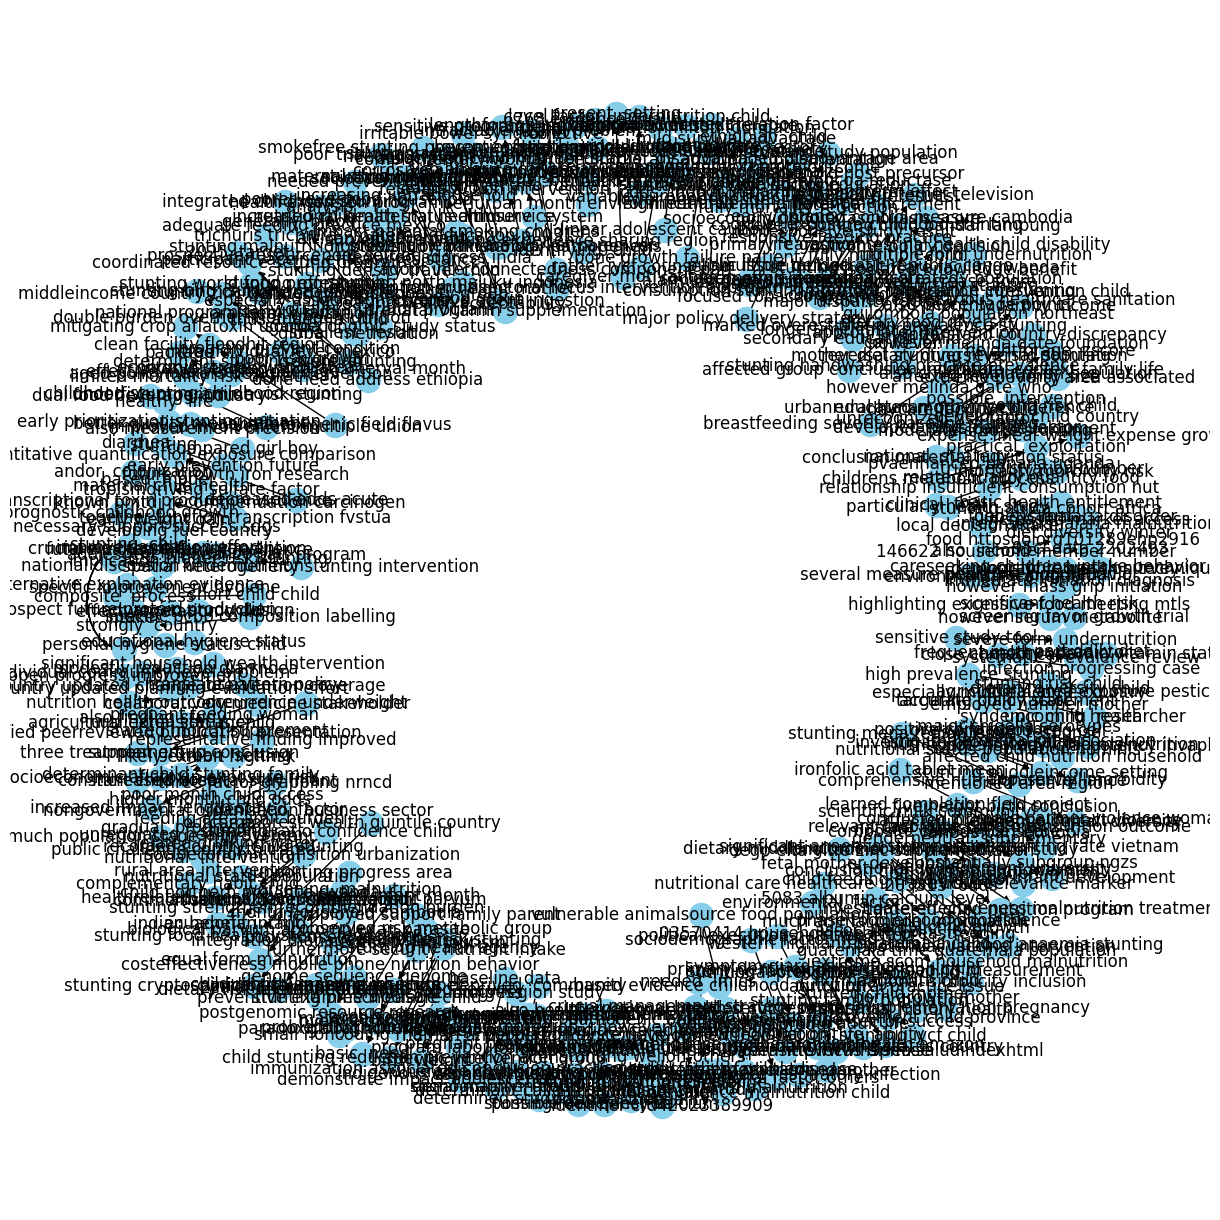

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()